# Metric Calculation
Calculate metrics for models run on the full dataset

## Imports and Data Loading

In [451]:
import xgboost
from xgboost import plot_importance
from bgpredict.helpers import S3Connection
from dotenv import load_dotenv
import multiprocessing
import json
import os
import numpy as np
from numpy.random import default_rng
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from skopt import BayesSearchCV, dump, load
from skopt.plots import plot_objective, plot_histogram
from s3fs.core import S3FileSystem
import matplotlib.pyplot as plt 

In [7]:
os.chdir('../')
load_dotenv()
os.chdir('./Notebooks')

In [8]:
def clean_data(df):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')

    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col, val)
    df = df.fillna(0)

    # Sort by timestamp
    current_len = len(df)
    df = df.loc[~(df['timestamp_clean'].apply(type) == int), :]
    print(f"Dropping {current_len - len(df)} invalid timestamps")
    df = df.sort_values(by="timestamp_clean")

    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)

    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0]

    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)

    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)

    return df

In [9]:
location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
engine = create_engine(location)
conn = engine.connect()
raw_df = pd.read_sql("select * from public.tb_final_dataset where test_set = 1", conn)
clean_df = clean_data(raw_df)

Null values to be filled by column:
bg_lag_1 6593
bg_lag_2 6449
bg_lag_3 6420
bg_lag_4 6548
bg_lag_5 6614
bg_lag_6 6577
bg_lag_7 6653
bg_lag_8 6720
bg_lag_9 6683
bg_lag_10 6694
bg_lag_11 6746
bg_lag_12 6758
Dropping 0 invalid timestamps


In [10]:
s3_conn = S3Connection()

## Helper Funcs

In [26]:
def graph_metrics(model_type, overall_metrics, by_subject_metrics, text_y):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))
    for idx, key in enumerate(by_subject_metrics):
        ax = axs[idx]
        ax.hist(by_subject_metrics[key], bins=100)
        ax.set_title(f"{key.upper()}")
        overall_metric = overall_metrics[key]
        vertical_line = ax.axvline(overall_metric, color='red', label=f'Test {key.upper()}')
        ax.text(x = overall_metric+ 0.01 * ax.get_xlim()[1], y=text_y, s=np.round(overall_metric, 2))
        x_coord = vertical_line.get_xdata()[1]
        ax.legend()
        ax.set_xlabel(f"{key.upper()}")
        plt.suptitle(f'{model_type} Evaluation Metrics by Subject', y=1.15, fontsize=15)
        plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
                  x=0.5, transform=fig.transFigure, fontsize=12)
        fig.supylabel("Subject Count", x=0.08)

## Arima

In [63]:
arima_locs = s3_conn.s3_client.list_objects_v2(Bucket=s3_conn.bucket_name, Prefix="models/arima/")
arima_locs['Contents']
result_uris = []
for x in arima_locs["Contents"]:
    path = x['Key']
    if "results" in path:
        uri = f"s3://{s3_conn.bucket_name}/{path}"
        result_uris.append(uri)
result_dfs= []
for uri in result_uris:
    df = pd.read_csv(uri)
    df.columns = ['subjectid', 'entryid', 'y', 'y_hat']
    result_dfs.append(df)
result_dfs[0].head()

,subjectid,entryid,y,y_hat
0,12689381,575,154.0,145.398916
1,12689381,574,147.0,147.389779
2,12689381,573,140.0,148.096161
3,12689381,572,134.0,147.715828
4,12689381,571,130.0,146.491036


In [64]:
arima_df = pd.concat(result_dfs)

# There are 162 rows where y == 0 which artificially inflates MAPE
arima_df = arima_df.loc[arima_df['y'] != 0,:]
print(arima_df.shape)

(1253986, 4)


In [65]:
test = arima_df.loc[arima_df['y_hat'] > 1000, :]
erroneous_subject =np.unique(test['subjectid'])[0]
print(erroneous_subject)
test.describe()

93839818


,subjectid,entryid,y,y_hat
count,13508.0,13508.000000,13508.000000,13508.000000
mean,93839818.0,201722.300933,120.995114,1932.249169
std,0.0,8532.815657,54.468599,538.248621
min,93839818.0,187136.000000,38.000000,1000.078731
25%,93839818.0,194159.500000,83.000000,1466.163950
50%,93839818.0,202201.000000,110.000000,1932.249169
75%,93839818.0,209226.500000,147.000000,2398.334388
max,93839818.0,216135.000000,400.000000,2864.419607


Subject 93839818's predictions are erroneous. Drop this subject when evaluating ARIMA metrics.

In [66]:
arima_df = arima_df.loc[arima_df['subjectid'] != erroneous_subject]

In [67]:
full_mse = mean_squared_error(arima_df['y'], arima_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(arima_df['y'], arima_df['y_hat'])
full_mape = mean_absolute_percentage_error(arima_df['y'], arima_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 8117.6496236625935
RMSE: 90.09800010911782
MAE: 57.78072210054919
MAPE: 0.5339585423736942


In [68]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = arima_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

In [69]:
def graph_metrics(model_type, overall_metrics, by_subject_metrics, text_y):
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,3))
    for idx, key in enumerate(by_subject_metrics):
        ax = axs[idx]
        ax.hist(by_subject_metrics[key], bins=100)
        ax.set_title(f"{key.upper()}")
        overall_metric = overall_metrics[key]
        vertical_line = ax.axvline(overall_metric, color='red', label=f'Test {key.upper()}')
        ax.text(x = overall_metric+ 0.01 * ax.get_xlim()[1], y=text_y, s=np.round(overall_metric, 2))
        x_coord = vertical_line.get_xdata()[1]
        ax.legend()
        ax.set_xlabel(f"{key.upper()}")
    _ = plt.suptitle('ARIMA Evaluation Metrics by Subject', y=1.15, fontsize=15)
    _ = plt.title('Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Prediction Error (MAPE)',
                  x=0.5, transform=fig.transFigure, fontsize=12)
    _ = fig.supylabel("Subject Count", x=0.08)

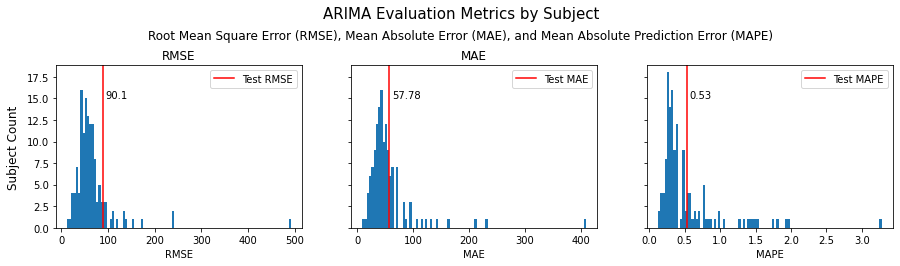

In [71]:
graph_metrics("ARIMA", full_metrics, metrics, 15)

(-100.0, 600.0)

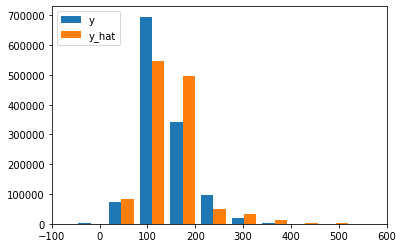

In [17]:
# _ = plt.hist(arima_df['y_hat'], bins=20, color='red')
_ = plt.hist([arima_df['y'], arima_df['y_hat']], bins=20, label = ['y', 'y_hat'])
plt.legend(loc="upper left")
plt.xlim(-100, 600)

## XGBoost

### XGBoost Load

In [12]:
# model_loc =  "models/xgboost/02.11.36.475845_L4607592"
model_loc = 'models/xgboost/11.21.42.393804_L4169251'

In [13]:
fs = S3FileSystem()
bst = xgboost.XGBRegressor()

path = "./model.json"
with fs.open(f"bgpredict/{model_loc}", 'rb') as f:
    bst.load_model(bytearray(f.read()))

### XGBoost Feature Importance

In [14]:
gain = bst.get_booster().get_score(importance_type='gain')
covers = bst.get_booster().get_score(importance_type='cover')
freq = bst.get_booster().get_score(importance_type='weight')

In [15]:
importances = list(zip(bst.feature_names_in_, bst.feature_importances_))
weekday = 0
subjectid = 0 
other = []
for x in importances:
    if 'ohe' in x[0]:
        indicator = x[0].split("_")[1]
        try:
            int(indicator)
            subjectid += x[1]
        except:
            weekday += x[1]
    else:
        key = x[0]
        if key == "normalized_carbs_datapercentile":
            k = "Carb Data Rank"
        elif key == "normalized_insulin_datapercentile":
            k = "Insulin Data Rank"
        elif key == "carbs_datacount":
            k = "Recorded Carb Count"
        elif key == "insulin_datacount":
            k = "Recorded Insulin Count"
        elif key == "datediff_currentbg_lastbg_inseconds":
            k = "Time Since Last BG"
        else:
            k = key.replace("_", " ")
        
        other.append((k, x[1]))
other.append(("Weekday Effects", weekday))
other.append(("Subject ID", subjectid))
other.sort(key=lambda x: x[1])
# other

Text(0.5, 1.0, 'XGBoost Feature Importance')

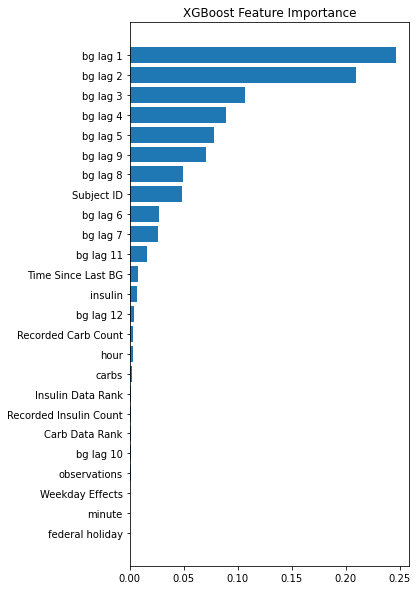

In [16]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(y=[x[0] for x in other], width=[x[1] for x in other])
plt.title("XGBoost Feature Importance")

### XGBoost Metrics

In [17]:
drop_cols = ['train_set', 'validation_set', 'test_set', 'subjectid', 'entryid', 'bg']
pred_df = clean_df.drop(drop_cols, axis=1)
preds = bst.predict(pred_df)

In [18]:
clean_df.loc[: , ['subjectid', 'entryid', 'bg']].reset_index()

,timestamp_clean,subjectid,entryid,bg
0,2016-08-10 00:43:50.664,68267781,43948,196.0
1,2016-08-10 00:48:51.032,68267781,43947,197.0
2,2016-08-10 01:13:49.950,68267781,43942,184.0
3,2016-08-10 01:23:49.686,68267781,43940,179.0
4,2016-08-10 01:33:50.462,68267781,43938,162.0
...,...,...,...,...
1305550,2021-03-18 23:36:58.983,56958831,29697,132.0
1305551,2021-03-18 23:41:59.650,56958831,29696,129.0
1305552,2021-03-18 23:46:58.908,56958831,29695,122.0
1305553,2021-03-18 23:51:59.718,56958831,29694,120.0


In [19]:
# rng = default_rng(46)
# subjects = clean_df.groupby("subjectid")['entryid'].count().sort_values()
# subjects = list(subjects.loc[subjects > 1000].index)
# drop_subjects = rng.choice(subjects, 14)
# drop_subjects
held_out_subjects = [60844515, 41131654, 40997757, 94200862, 91161972, 28608066,
       76817975, 37875431, 63047517, 72492570, 80796147, 87770486,
       95851255, 70454270]

In [20]:
y_hat = pd.Series(preds, name='y_hat')
dfs = [clean_df.loc[:, ['subjectid', 'entryid', 'bg']].reset_index(drop=True), y_hat]
xgboost_df = pd.concat(dfs, axis=1, ignore_index=True)
xgboost_df.columns = ["subjectid", "entryid", "y", "y_hat"]
# Drop 162 0 values which artificially inflate MAPE 
xgboost_df = xgboost_df.loc[ xgboost_df['y'] !=0, :]
xgboost_df.head()

,subjectid,entryid,y,y_hat
0,68267781,43948,196.0,195.525818
1,68267781,43947,197.0,200.001999
2,68267781,43942,184.0,195.169403
3,68267781,43940,179.0,184.083710
4,68267781,43938,162.0,174.461395


In [21]:
hold_out_df = xgboost_df.loc[xgboost_df.subjectid.isin(held_out_subjects), :]
in_sample_df = xgboost_df.loc[~xgboost_df.subjectid.isin(held_out_subjects), :]

In [22]:
full_mse = mean_squared_error(in_sample_df['y'], in_sample_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(in_sample_df['y'], in_sample_df['y_hat'])
full_mape = mean_absolute_percentage_error(in_sample_df['y'], in_sample_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 155.81821034978262
RMSE: 12.482716465168254
MAE: 6.063082698130701
MAPE: 0.06385485558665073


In [23]:
full_mse = mean_squared_error(hold_out_df['y'], hold_out_df['y_hat'])
full_rmse = np.sqrt(full_mse)
full_mae = mean_absolute_error(hold_out_df['y'], hold_out_df['y_hat'])
full_mape = mean_absolute_percentage_error(hold_out_df['y'], hold_out_df['y_hat'])
print(f'MSE: {full_mse}')
print(f'RMSE: {full_rmse}')
print(f'MAE: {full_mae}')
print(f'MAPE: {full_mape}')
full_metrics = {'rmse':full_rmse, "mae": full_mae, "mape": full_mape}

MSE: 179.64949186231453
RMSE: 13.403338832631015
MAE: 6.0331813809360755
MAPE: 0.06675165869624046


In [24]:
metrics = {'rmse':[], "mae": [], "mape": []}
grouped = xgboost_df.groupby('subjectid')
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(group['y'], group['y_hat'])
    mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    if mape >1000:
        print(group['subjectid'].iloc[0])
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['mape'].append(mape)

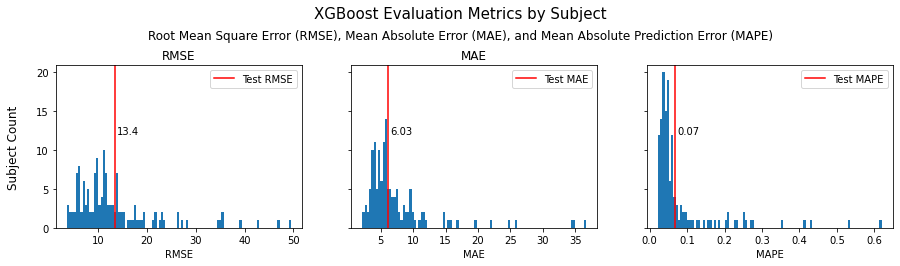

In [62]:
graph_metrics("XGBoost", full_metrics, metrics, 12)

In [40]:
test = []
for name, group in grouped:
    mse = mean_squared_error(group['y'], group['y_hat'])
    rmse = np.sqrt(mse)
#     mae = mean_absolute_error(group['y'], group['y_hat'])
#     mape = mean_absolute_percentage_error(group['y'], group['y_hat'])
    std_dev = np.std(group['y'])
#     print(std_dev)
    test.append((rmse, std_dev))
    

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
rmse = np.array([x[0] for x in test])
std_dev = np.array([x[1] for x in test]).reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X=std_dev, y=rmse)
preds = regressor.predict(std_dev)

In [43]:
regression_line = [float(regressor.intercept_ + i * regressor.coef_) for i in range(90)]

In [44]:
r_sq = r2_score(rmse, preds)
r_sq

0.1630668785173628

Text(0.5, 1.0, 'R^2 = 0.16')

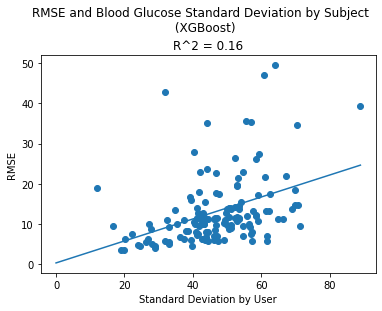

In [45]:
plt.scatter([x[1] for x in test], [x[0] for x in test])
plt.ylabel("RMSE")
plt.xlabel("Standard Deviation by User")
plt.plot(regression_line)
plt.suptitle("RMSE and Blood Glucose Standard Deviation by Subject \n (XGBoost)", y=1.05)
plt.title(f"R^2 = {np.round(r_sq, 2)}")

## Predict Forward
### Future Y

In [365]:
clean_df['bg'].head()

timestamp_clean
2016-08-10 00:43:50.664    196.0
2016-08-10 00:48:51.032    197.0
2016-08-10 01:13:49.950    184.0
2016-08-10 01:23:49.686    179.0
2016-08-10 01:33:50.462    162.0
Name: bg, dtype: float64

In [208]:
def create_future_y(df):
    future_preds_out = []
    groups = df.groupby('subjectid')
    for name, group in groups:
        group_df = group.sort_index()
        group_df = group_df.reset_index()
        original = group_df[["subjectid", "entryid", 'bg']]
        shifts = pd.DataFrame({f"bg_future_{i}": original['bg'].shift(-i) for i in range(1,13)})
        preds = pd.DataFrame({f"bg_pred_{i}": [None for _ in range(len(original))] for i in range(1,13)} )
        merged = original.merge(shifts, left_index=True, right_index=True)
        merged = pd.concat([merged, preds], axis=1)
        future_preds_out.append(merged)
    result = pd.concat(future_preds_out, axis=0)
    return result 

In [209]:
future_y_df = create_future_y(clean_df)
print(future_y_df.shape)
future_y_df.head()

(1305555, 27)


,subjectid,entryid,bg,bg_future_1,bg_future_2,bg_future_3,bg_future_4,bg_future_5,bg_future_6,bg_future_7,...,bg_pred_3,bg_pred_4,bg_pred_5,bg_pred_6,bg_pred_7,bg_pred_8,bg_pred_9,bg_pred_10,bg_pred_11,bg_pred_12
0,221634,17572,125.0,120.0,117.0,114.0,114.0,114.0,115.0,117.0,...,None,None,None,None,None,None,None,None,None,None
1,221634,17571,120.0,117.0,114.0,114.0,114.0,115.0,117.0,114.0,...,None,None,None,None,None,None,None,None,None,None
2,221634,17570,117.0,114.0,114.0,114.0,115.0,117.0,114.0,113.0,...,None,None,None,None,None,None,None,None,None,None
3,221634,17568,114.0,114.0,114.0,115.0,117.0,114.0,113.0,113.0,...,None,None,None,None,None,None,None,None,None,None
4,221634,17566,114.0,114.0,115.0,117.0,114.0,113.0,113.0,106.0,...,None,None,None,None,None,None,None,None,None,None


### Future X

In [425]:
## Column Prep

# constant_columns = []
# for column in test.columns:
#     if np.isclose(np.std(test[column]), 0):
#         constant_columns.append(column)
# mutable_columns = list(test.columns.difference(constant_columns))

# I'm being exceptionally explicit with the mutable/constant columns. The above code *should*
# compute this list for any data passed into it. However, I worry edge cases could break break it. 

mutable_columns = ['bg_lag_1', 'bg_lag_10', 'bg_lag_11', 'bg_lag_12', 'bg_lag_2', 'bg_lag_3', 'bg_lag_4', 'bg_lag_5',
                   'bg_lag_6', 'bg_lag_7', 'bg_lag_8', 'bg_lag_9', 'carbs', 'datediff_currentbg_lastbg_inseconds',
                   'federal_holiday', 'hour', 'insulin', 'minute', 'ohe_Friday', 'ohe_Monday', 'ohe_Saturday',
                   'ohe_Sunday', 'ohe_Thursday', 'ohe_Tuesday', 'ohe_Wednesday']
constant_columns = ['ohe_221634', 'ohe_309157', 'ohe_897741', 'ohe_1352464', 'ohe_2033176', 'ohe_2199852', 'ohe_4762925',
                    'ohe_5274556', 'ohe_7886752', 'ohe_12689381', 'ohe_13029224', 'ohe_13484299', 'ohe_13783771',
                    'ohe_14092221', 'ohe_15558575', 'ohe_15634563', 'ohe_16975609', 'ohe_17161370', 'ohe_18991425',
                    'ohe_19626656', 'ohe_20216809', 'ohe_20396154', 'ohe_20649783', 'ohe_21946407', 'ohe_22961398',
                    'ohe_23428091', 'ohe_24448124', 'ohe_25692073', 'ohe_26856617', 'ohe_27526291', 'ohe_27819368',
                    'ohe_28176124', 'ohe_28608066', 'ohe_28756888', 'ohe_28768536', 'ohe_32407882', 'ohe_32997134',
                    'ohe_33470634', 'ohe_33831564', 'ohe_33962890', 'ohe_35533061', 'ohe_35719805', 'ohe_37764532',
                    'ohe_37875431', 'ohe_37948668', 'ohe_37998755', 'ohe_38110191', 'ohe_39986716', 'ohe_40237051',
                    'ohe_40634871', 'ohe_40997757', 'ohe_41131654', 'ohe_41663654', 'ohe_42052178', 'ohe_43589707',
                    'ohe_45120081', 'ohe_46253612', 'ohe_47323535', 'ohe_47750728', 'ohe_48509634', 'ohe_48540630',
                    'ohe_49551394', 'ohe_49796612', 'ohe_50311906', 'ohe_51968000', 'ohe_54280576', 'ohe_56568290',
                    'ohe_56958831', 'ohe_57176789', 'ohe_60844515', 'ohe_61179686', 'ohe_62345070', 'ohe_62401782',
                    'ohe_63047517', 'ohe_63725802', 'ohe_64024750', 'ohe_64406000', 'ohe_65143138', 'ohe_66019205',
                    'ohe_66773091', 'ohe_66836068', 'ohe_66937570', 'ohe_67167655', 'ohe_67208817', 'ohe_67359234',
                    'ohe_68026248', 'ohe_68267781', 'ohe_69587086', 'ohe_69739062', 'ohe_69965708', 'ohe_70454270',
                    'ohe_70811987', 'ohe_71236754', 'ohe_71397255', 'ohe_71618088', 'ohe_72492570', 'ohe_73398408',
                    'ohe_73521474', 'ohe_74077367', 'ohe_76817975', 'ohe_77104076', 'ohe_77411181', 'ohe_78420229',
                    'ohe_79526193', 'ohe_80373992', 'ohe_80501215', 'ohe_80625186', 'ohe_80796147', 'ohe_81099003',
                    'ohe_81680176', 'ohe_84109428', 'ohe_84589080', 'ohe_84984656', 'ohe_85199788', 'ohe_85653830',
                    'ohe_86025410', 'ohe_86286077', 'ohe_86323903', 'ohe_87770486', 'ohe_88004055', 'ohe_88252802',
                    'ohe_89032650', 'ohe_89710417', 'ohe_89727223', 'ohe_90398368', 'ohe_91161972', 'ohe_93606058',
                    'ohe_93839818', 'ohe_94200862', 'ohe_95614431', 'ohe_95851255', 'ohe_96254963', 'ohe_96805916',
                    'ohe_97417885', 'ohe_97872409', 'ohe_98340749', 'ohe_98974339', 'ohe_99296581', 'ohe_99712241',
                    'ohe_99848889', 'ohe_99908129', 'observations', 'insulin_datacount', 'carbs_datacount',
                    'normalized_carbs_datapercentile', 'normalized_insulin_datapercentile']

# We don't know future carbs or insulin, so we set this value to zero 
for i in ['carbs', 'insulin']:
    mutable_columns.pop(mutable_columns.index(i))
    constant_columns.append(i)

# Extract Lag columns to modify
lag_columns = []
for i in range(1,13):
    idx = mutable_columns.index(f"bg_lag_{i}")
    lag_columns.append(mutable_columns.pop(idx))
# Expeted input order
ordered_features = bst.feature_names_in_

col_info = {"mutable": mutable_columns,
           "constant": constant_columns,
           "lag": lag_columns, 
           "order": ordered_features}

In [572]:
def create_future_y(group):
    """Take a group of subject data and return the future y dataframe"""
    group_df = group.sort_index()
    group_df = group_df.reset_index()
    original = group_df[["subjectid", "entryid", 'bg']]
    shifts = pd.DataFrame({f"bg_future_{i}": original['bg'].shift(-i) for i in range(1,13)})
    preds = pd.DataFrame({f"bg_pred_{i}": [None for _ in range(len(original))] for i in range(0,13)} )
    merged = original.merge(shifts, left_index=True, right_index=True)
    merged = pd.concat([merged, preds], axis=1)
    return merged

def create_future_mutables(mutable):
    """Take mutable variables,apply a -1 shift, and drop end NA's"""
    # Each row now contains the data of the suceeding row
    shift = mutable_df.shift(-1)
    # Len(shift) = max(idx)+1, len(shift)-1 = max(idx), len(shift-2) = location of Null row
    shift = shift.loc[0:len(shift)-2, :]
    return shift

def create_future_lags(lag_df, preds):
    """Take lag variables and predictions and apply a shift"""

    # Shift lags
    for j in range(12, 0, -1):
        if j == 1:
            current_column = f"bg_lag_{j}" # lag_bg_1
            lag_df.loc[:, current_column] = pd.to_numeric(preds)
        else:
            current_column = f"bg_lag_{j}"
            prev_column = f"bg_lag_{j-1}"
            lag_df.loc[:, current_column] = lag_df[prev_column] 
    return lag_df

    # Create new df
    new_df = pd.concat([mutable_df, constant_df, lag_df], axis=1)
    new_df = new_df.reindex(columns=col_info['order'])
    
def compute_future_predictions(group):
    
    # Create Future y dataframe
    future_y_df = create_future_y(group)

    # Create X subset dataframes
    drop_cols = ['subjectid', 'entryid', 'train_set', 'validation_set', 'test_set', 'bg', 'timestamp_clean']
    group = group.sort_index()    
    group = group.reset_index()
    group = group.drop(drop_cols, axis=1)
    mutable_df = group[col_info['mutable']]
    constant_df = group[col_info['constant']]
    lag_df = group[col_info['lag']]
    
    # Generate initial prediction 
    train_X = pd.concat([mutable_df, constant_df, lag_df], axis=1)
    train_X = train_X.reindex(columns = col_info['order'])
    init_preds = bst.predict(train_X)
    if np.isnan(init_preds).any():
        raise Exception() 
    future_y_df['bg_pred_0'] = init_preds

    constant_df['carbs'] = 0
    constant_df['insulin'] = 0
    
    # Predict forward
    for i in range(13):
        mutable_df = create_future_mutables(mutable_df)
        if i == 0:
            lag_df = create_future_lags(lag_df, init_preds)
        else:
            lag_df = create_future_lags(lag_df, preds)
        train_X = pd.concat([mutable_df, lag_df, constant_df], axis=1)
        train_X = train_X.dropna()
        train_X = train_X.reindex(columns = col_info['order'])
        preds = bst.predict(train_X)
        
        if np.isnan(init_preds).any():
            raise Exception() 
        
        # As we move forward, we lose data to predict against, so we augment with nulls to get matching indices
        augment_size = len(future_y_df) - len(preds)
        
        preds = np.concatenate( (preds, [None for _ in range(augment_size)]) ) 

        future_y_df[f'bg_pred_{i}'] = preds
    
    loss = {f'future_{i}': None for i in range(1,13)}
    for i in range(1,13):
        pred = future_y_df[f'bg_pred_{i}'].dropna()
        true = future_y_df.loc[:,f'bg_future_{i}'].dropna()
        if len(pred) < len(true):
            true = true.loc[0:len(pred)-1]
#             print(pred.shape, true.shape)
        elif len(pred) > len(true):
            pred = pred.loc[0:len(true)-1]
            
        loss[f'future_{i}'] = true - pred
        mse = mean_squared_error(true, pred)
        
    return future_y_df, loss

In [571]:
results = [] 
losses = []
nas ={}
held_out_subjects = [60844515, 41131654, 40997757, 94200862, 91161972, 28608066,
       76817975, 37875431, 63047517, 72492570, 80796147, 87770486,
       95851255, 70454270]
for name, group in groups:
    if name in held_out_subjects:
        pass
    else:
        result_df, loss = compute_future_predictions(group)
        results.append(result_df)
        losses.append(loss)
        nas.update({name: result_df.isna().sum()})

In [580]:
loss_dfs = [pd.DataFrame(loss) for loss in losses]
loss_df = pd.concat(loss_dfs)
loss_df.head()
for c in loss_df.columns:
    n = len(loss_df)
    squared_loss = (loss_df[c] ** 2).sum()
    print(np.sqrt(squared_loss/n))

18.003424000014352
22.21090961565299
25.894363528708336
29.15721842840204
32.05177254886531
34.655032627637226
36.97168010472375
39.0631756715589
40.946737230016026
42.649995002650726
44.20403219848989
45.63628679008282


In [576]:
(loss_df['future_1'] ** 2).sum()

281247276.4416561

In [547]:
nas[309157]

subjectid          0
entryid            0
bg                 0
bg_future_1        1
bg_future_2        2
bg_future_3        3
bg_future_4        4
bg_future_5        5
bg_future_6        6
bg_future_7        7
bg_future_8        8
bg_future_9        9
bg_future_10      10
bg_future_11      11
bg_future_12      12
bg_pred_0       1297
bg_pred_1       1297
bg_pred_2       1297
bg_pred_3       1297
bg_pred_4       1297
bg_pred_5       1297
bg_pred_6       1297
bg_pred_7       1297
bg_pred_8       1297
bg_pred_9       1297
bg_pred_10      1297
bg_pred_11      1297
bg_pred_12      1297
dtype: int64

In [556]:
# nas
group = groups.get_group(309157)
result = compute_future_predictions(group)
result.isna().sum()

subjectid        0
entryid          0
bg               0
bg_future_1      1
bg_future_2      2
bg_future_3      3
bg_future_4      4
bg_future_5      5
bg_future_6      6
bg_future_7      7
bg_future_8      8
bg_future_9      9
bg_future_10    10
bg_future_11    11
bg_future_12    12
bg_pred_0       14
bg_pred_1       14
bg_pred_2       14
bg_pred_3       14
bg_pred_4       14
bg_pred_5       14
bg_pred_6       14
bg_pred_7       14
bg_pred_8       14
bg_pred_9       14
bg_pred_10      14
bg_pred_11      14
bg_pred_12      14
dtype: int64

In [557]:
# Create Future y dataframe
future_y_df = create_future_y(group)

# Create X subset dataframes
drop_cols = ['subjectid', 'entryid', 'train_set', 'validation_set', 'test_set', 'bg', 'timestamp_clean']
group = group.sort_index()    
group = group.reset_index()
group = group.drop(drop_cols, axis=1)
mutable_df = group[col_info['mutable']]
constant_df = group[col_info['constant']]
lag_df = group[col_info['lag']]

# Generate initial prediction 
train_X = pd.concat([mutable_df, constant_df, lag_df], axis=1)
train_X = train_X.reindex(columns = col_info['order'])
init_preds = bst.predict(train_X)
if np.isnan(init_preds).any():
    raise Exception() 
future_y_df['bg_pred_0'] = init_preds

constant_df['carbs'] = 0
constant_df['insulin'] = 0

# Predict forward
for i in range(13):
    mutable_df = create_future_mutables(mutable_df)
    if i == 0:
        lag_df = create_future_lags(lag_df, init_preds)
    else:
        lag_df = create_future_lags(lag_df, preds)
    train_X = pd.concat([mutable_df, lag_df, constant_df], axis=1)
    train_X = train_X.dropna()
    train_X = train_X.reindex(columns = col_info['order'])
    preds = bst.predict(train_X)

    if np.isnan(init_preds).any():
        raise Exception() 

    # As we move forward, we lose data to predict against, so we augment with nulls to get matching indices
    augment_size = len(future_y_df) - len(preds)

    preds = np.concatenate( (preds, [None for _ in range(augment_size)]) ) 

    future_y_df[f'bg_pred_{i}'] = preds


for i in range(1,13):
    pred = future_y_df[f'bg_pred_{i}'].dropna()
    true = future_y_df.loc[0:len(pred)-1 ,f'bg_future_{i}'].dropna()
    loss = true-pred
    mse = mean_squared_error(true, pred)
    

1.9006381292039625
2.9501298089174783
4.1799961277978825
5.586396946203592
7.134853943103759
8.765835917120855
10.457571893995365
12.1862072971414
13.958582748633042
15.730828102091992
17.48755843681342
19.21864456034774


In [518]:
mutable_df = create_future_mutables(mutable_df)
mutable_df.isna().sum()

datediff_currentbg_lastbg_inseconds    0
federal_holiday                        0
hour                                   0
minute                                 0
ohe_Friday                             0
ohe_Monday                             0
ohe_Saturday                           0
ohe_Sunday                             0
ohe_Thursday                           0
ohe_Tuesday                            0
ohe_Wednesday                          0
dtype: int64

In [519]:
lag_df = create_future_lags(lag_df, init_preds)
lag_df.isna().sum()

bg_lag_1     0
bg_lag_2     0
bg_lag_3     0
bg_lag_4     0
bg_lag_5     0
bg_lag_6     0
bg_lag_7     0
bg_lag_8     0
bg_lag_9     0
bg_lag_10    0
bg_lag_11    0
bg_lag_12    0
dtype: int64

In [520]:
constant_df.isna().sum()

ohe_221634                           0
ohe_309157                           0
ohe_897741                           0
ohe_1352464                          0
ohe_2033176                          0
                                    ..
carbs_datacount                      0
normalized_carbs_datapercentile      0
normalized_insulin_datapercentile    0
carbs                                0
insulin                              0
Length: 148, dtype: int64

In [524]:
print(future_y_df.shape)
future_y_df.isna().sum()

(10648, 28)


subjectid           0
entryid             0
bg                  0
bg_future_1         1
bg_future_2         2
bg_future_3         3
bg_future_4         4
bg_future_5         5
bg_future_6         6
bg_future_7         7
bg_future_8         8
bg_future_9         9
bg_future_10       10
bg_future_11       11
bg_future_12       12
bg_pred_0           0
bg_pred_1       10648
bg_pred_2       10648
bg_pred_3       10648
bg_pred_4       10648
bg_pred_5       10648
bg_pred_6       10648
bg_pred_7       10648
bg_pred_8       10648
bg_pred_9       10648
bg_pred_10      10648
bg_pred_11      10648
bg_pred_12      10648
dtype: int64

In [526]:
train_X = pd.concat([mutable_df, lag_df, constant_df], axis=1)
train_X = train_X.dropna()
train_X = train_X.reindex(columns = col_info['order'])
(train_X.isna().sum() > 1).any()

False

In [529]:
preds = bst.predict(train_X)

if np.isnan(init_preds).any():
    raise Exception() 
    
print(preds.shape)

(10646,)


# -------------------------------

In [534]:
test.loc[0, :]

,subjectid,entryid,bg,bg_future_1,bg_future_2,bg_future_3,bg_future_4,bg_future_5,bg_future_6,bg_future_7,...,bg_pred_3,bg_pred_4,bg_pred_5,bg_pred_6,bg_pred_7,bg_pred_8,bg_pred_9,bg_pred_10,bg_pred_11,bg_pred_12
0,221634,17572,125.0,120.0,117.0,114.0,114.0,114.0,115.0,117.0,...,117.167625,115.217499,112.998398,111.023918,109.502121,107.960793,106.865219,105.193085,103.460503,99.606583
0,309157,48686,101.0,99.0,94.0,88.0,82.0,77.0,75.0,75.0,...,101.062492,99.207901,98.139778,96.790222,95.917931,95.484055,94.717873,94.717873,94.679962,94.177261
0,897741,162609,104.0,104.0,104.0,104.0,109.0,110.0,108.0,104.0,...,98.675232,97.997749,96.532654,95.660362,95.226486,94.460304,92.648224,91.789215,90.58709,89.645271
0,1352464,135422,109.0,107.0,105.0,113.0,103.0,98.0,93.0,94.0,...,98.006142,96.541046,95.784294,95.350418,94.584236,94.584236,94.546326,94.043625,92.231544,90.711021
0,2033176,30621,277.0,270.0,265.0,262.0,259.0,253.0,246.0,240.0,...,228.631943,217.301559,211.83165,206.128494,196.165665,192.041367,187.007507,180.401489,175.565643,171.36232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,98974339,33554,139.0,131.0,123.0,135.0,118.0,115.0,95.0,86.0,...,153.094315,149.559204,149.791824,149.305359,146.492462,143.662277,141.045502,139.206085,137.595169,133.642471
0,99296581,1664,91.0,84.0,86.0,86.0,82.0,84.0,95.0,111.0,...,90.907661,90.117287,88.483643,87.020187,86.172737,85.767982,86.072578,86.072578,86.072578,86.072578
0,99712241,10341,163.0,161.0,162.0,163.0,162.0,161.0,159.0,157.0,...,171.3759,173.352356,172.160263,170.712158,170.712158,170.712158,169.206863,168.69606,168.69606,166.719604
0,99848889,256689,137.0,138.0,139.0,139.0,139.0,142.0,145.0,144.0,...,143.935745,143.15683,141.0354,141.043839,139.392548,139.130707,137.910049,134.866058,133.452072,130.345917


In [537]:
r = pd.concat(results)
test = r
for i in range(0,13):
    if i == 0:
        pred = test[f"bg_pred_0"]
        true = test
    else:
        pred = test[f'bg_pred_{i}']
        pred = pred.dropna()
        true = test.iloc[0:len(pred), :][f'bg_future_{i}']
        print(mean_squared_error(true, pred))

ValueError: Input contains NaN.

In [483]:
test = groups.get_group(221634)

# Create future y dataframe
future_y_df = create_future_y(test)

# Create X subset dataframes
drop_cols = ['subjectid', 'entryid', 'train_set', 'validation_set', 'test_set', 'bg', 'timestamp_clean']
test = test.sort_index()    
test = test.reset_index()
test = test.drop(drop_cols, axis=1)
mutable_df = test[col_info['mutable']]
constant_df = test[col_info['constant']]
lag_df = test[col_info['lag']]

In [484]:
# Generate initial prediction 
train_X = pd.concat([mutable_df, constant_df, lag_df], axis=1)
train_X = train_X.reindex(columns = col_info['order'])
init_preds = bst.predict(train_X)
future_y_df['bg_pred_0'] = init_preds

constant_df['carbs'] = 0
constant_df['insulin'] = 0

for i in range(13):
    mutable_df = create_future_mutables(mutable_df)
    if i == 0:
        lag_df = create_future_lags(lag_df, init_preds)
    else:
        lag_df = create_future_lags(lag_df, preds)
    train_X = pd.concat([mutable_df, lag_df, constant_df], axis=1)
    train_X = train_X.dropna()
    train_X = train_X.reindex(columns = col_info['order'])
    preds = bst.predict(train_X)
    
    # As we move forward, we lose data to predict against, so we augment with nulls to get matching indices
    augment_size = len(future_y_df) - len(preds)
    preds = np.concatenate( (preds, [None for _ in range(augment_size)]) ) 
    
    future_y_df[f'bg_pred_{i}'] = preds

In [496]:
for i in range(0,13):
    if i == 0:
        pred = test[f"bg_pred_0"]
        true = test
    else:
        pred = test[f'bg_pred_{i}']
        pred = pred.dropna()
        true = test.loc[0:len(pred)-1, f'bg_future_{i}']
        print(mean_squared_error(true, pred))

KeyError: 'Cannot get left slice bound for non-unique label: 0'

In [458]:
del future_y_df
del test
del mutable_df
del constant_df
del lag_df 
del preds
del pred
del true

In [432]:
mean_squared_error(true, pred)

3315.7822721042185

In [437]:
test = groups.get_group(309157)

# Create future y dataframe
future_y_df = create_future_y(test)

# Create X subset dataframes
drop_cols = ['subjectid', 'entryid', 'train_set', 'validation_set', 'test_set', 'bg', 'timestamp_clean']
test = test.sort_index()    
test = test.reset_index()
test = test.drop(drop_cols, axis=1)
test.head()
mutable_df = test[col_info['mutable']]
constant_df = test[col_info['constant']]
lag_df = test[col_info['lag']]

# Generate initial prediction 
train_X = pd.concat([mutable_df, constant_df, lag_df], axis=1)
train_X = train_X.reindex(columns = col_info['order'])
init_preds = bst.predict(train_X)
future_y_df['bg_pred_0'] = init_preds

mutable_df = create_future_mutables(mutable_df)
lag_df = create_future_lags(lag_df, preds)
train_X = pd.concat([mutable_df, lag_df, constant_df], axis=1).dropna()

,datediff_currentbg_lastbg_inseconds,federal_holiday,hour,minute,ohe_Friday,ohe_Monday,ohe_Saturday,ohe_Sunday,ohe_Thursday,ohe_Tuesday,...,ohe_99712241,ohe_99848889,ohe_99908129,observations,insulin_datacount,carbs_datacount,normalized_carbs_datapercentile,normalized_insulin_datapercentile,carbs,insulin
0,299.0,0.0,0.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
1,301.0,0.0,0.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
2,300.0,0.0,0.0,22.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
3,300.0,0.0,0.0,27.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
4,300.0,0.0,0.0,32.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11898,300.0,0.0,20.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
11899,300.0,0.0,20.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
11900,301.0,0.0,20.0,35.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0
11901,299.0,0.0,20.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,59399,1843,1488,0.75,0.635714,0.0,0.0


In [436]:
# Need to think about this ordering a bit 
# true_series = future_y_df.loc[~future_y_df['bg_future_1'].isna(), 'bg']
# pred_series = future_y_df.loc[0:len(true_series)-1, 'bg_pred_1']                              
mean_squared_error(future_y_df['bg'], init_preds)

165.02172370774724

## LSTM